In [168]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import numba

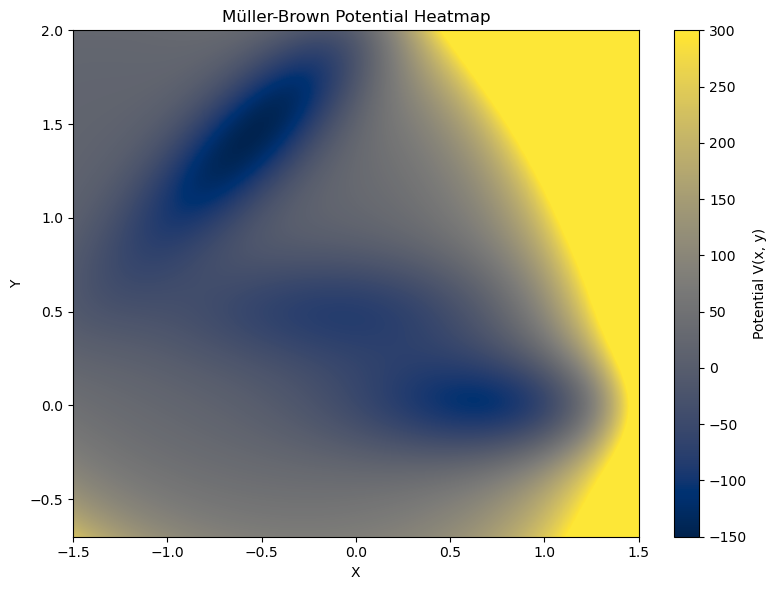

In [ ]:

# Define the coefficients
A = np.array([-200.0, -100.0, -170.0, 15.0])
a = np.array([-1.0, -1.0, -6.5, 0.7])
b = np.array([0.0, 0.0, 11.0, 0.6])
c = np.array([-10.0, -10.0, -6.5, 0.7])
x0 = np.array([1.0, 0.0, -0.5, -1.0])
y0 = np.array([0.0, 0.5, 1.5, 1.0])

@numba.vectorize(['float64(float64, float64)'])
def mullerBrownPotential(x: np.float64, y):
    zi = A * np.exp(a * (x - x0)**2 + b * (x - x0) * (y - y0) + c * (y - y0)**2)
    return np.sum(zi)

@numba.vectorize(['float64(float64, float64)'])
def mullerBrownGradient_dx(x, y):
    zi = A * np.exp(a * (x - x0)**2 + b * (x - x0) * (y - y0) + c * (y - y0)**2)
    dx = np.sum((2 * a * (x - x0) + b * (y - y0)) * zi)
    return dx

@numba.vectorize(['float64(float64, float64)'])
def mullerBrownGradient_dy(x, y):
    zi = A * np.exp(a * (x - x0)**2 + b * (x - x0) * (y - y0) + c * (y - y0)**2)
    dy = np.sum((b * (x - x0) + 2 * c * (y - y0)) * zi)
    return dy

def mullerBrownHeatmap(N, xrange=(-1.5, 1.5), yrange=(-0.7, 2.0)):
    x = np.linspace(*xrange, N)
    y = np.linspace(*yrange, N)
    X, Y = np.meshgrid(x, y)
    Z = mullerBrownPotential(X, Y)
    return X, Y, Z

@numba.njit
def mullerBrownPotentialAndGradient(pos):
    return mullerBrownPotential(pos[0], pos[1]), mullerBrownGradient_dx(pos[0], pos[1]), mullerBrownGradient_dy(pos[0], pos[1])



def plot_muller_brown_heatmap(trj = None, cmap='cividis', vmin=-150, vmax=300, return_fig=False):
    """
    Plots a heatmap of the Müller-Brown potential with colorbar limits set between vmin and vmax.

    Parameters:
    - X (numpy.ndarray): 2D array of x-coordinates.
    - Y (numpy.ndarray): 2D array of y-coordinates.
    - Z (numpy.ndarray): 2D array of potential values.
    - cmap (str): Colormap for the heatmap. Default is 'plasma'.
    - vmin (float): Minimum value for color scaling. Default is -300.
    - vmax (float): Maximum value for color scaling. Default is 300.
    """
    
    X, Y, Z = mullerBrownHeatmap(500)

    fig, ax = plt.subplots(figsize=(8, 6))
    # Create the heatmap using imshow with specified vmin and vmax
    # To ensure correct aspect ratio and orientation, we set extent and origin
    extent = [X.min(), X.max(), Y.min(), Y.max()]
    im = ax.imshow(Z, extent=extent, origin='lower', cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)

    # Add a colorbar to show the potential scale
    cbar = plt.colorbar(im)
    cbar.set_label('Potential V(x, y)')

    # Label the axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Müller-Brown Potential Heatmap')
    
    if trj is not None:
        ax.plot(*trj.T, c='red', lw=0.1)

    fig.tight_layout()
  
    if return_fig:
        return fig, ax
    else:
        plt.show()

plot_muller_brown_heatmap()


In [242]:
@numba.njit
def velocityVerlet(n, eInit=50.0):

    pos = np.zeros((n, 2))
    conserved = np.zeros(n // 1000)
    pos[0] = np.array([-0.55, 1.44])
    
    u, dudx, dudy = mullerBrownPotentialAndGradient(pos[0])
    
    eKin = eInit - u
    if eKin < 1.0:
        eKin = 1.0
    vInit = np.sqrt(eKin)
    vel = np.zeros(2)
    theta = 2 * np.pi * np.random.rand()
    vel[0] = vInit * np.cos(theta)
    vel[1] = vInit * np.sin(theta)
    print(u, np.sum(vel**2))
    
    dt = 5e-4

    for i in range(n-1):
        pos[i+1] = pos[i] + vel * dt + 0.5 * np.array([-dudx, -dudy]) * dt**2
        vel += 0.5 * np.array([-dudx, -dudy]) * dt
        u, dudx, dudy = mullerBrownPotentialAndGradient(pos[i+1])
        vel += 0.5 * np.array([-dudx, -dudy]) * dt
        
        if i % 1000 == 0:
            conserved[i//1000] = u + 0.5 * np.sum(vel**2)
    return pos, conserved
    
@numba.njit
def langevin(n, T=1.0):
    pos = np.zeros((n, 2))
    vel = np.zeros(2)
    pos[0] = np.array([-0.5, 1.2])
    vel = 10.0 * np.random.rand(2)
    u, dudx, dudy = mullerBrownPotentialAndGradient(pos[0])

    dt = 5e-4
    
    gamma = 1.0
    theta = np.exp(-gamma * dt)
    sigma = np.sqrt((1-theta**2) * T)

    for i in range(n-1):
        vel += 0.5 * np.array([-dudx, -dudy]) * dt
        vel = theta * vel + sigma * np.random.randn(2)
        
        pos[i+1] = pos[i] + 0.5 * vel * dt
        
        u, dudx, dudy = mullerBrownPotentialAndGradient(pos[i+1])
        
        vel += 0.5 * np.array([-dudx, -dudy]) * dt
    return pos

pos = langevin(int(1e7), T=12.0)

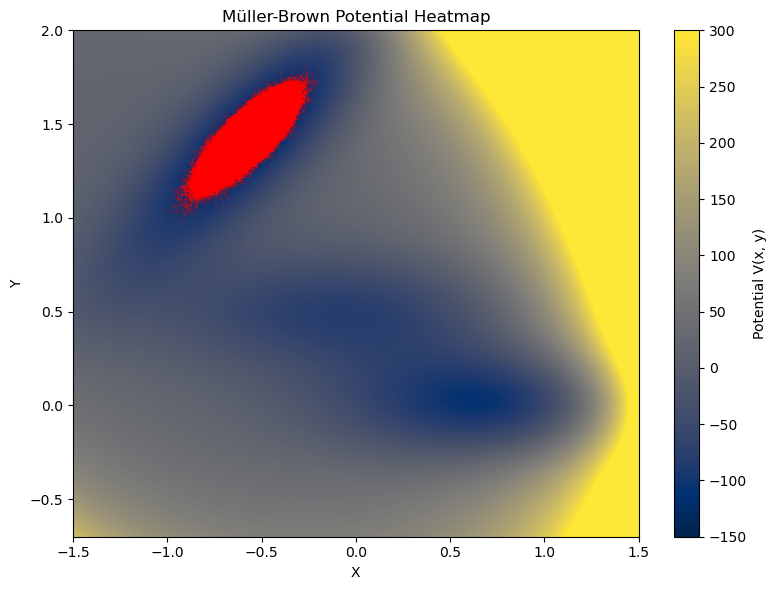

In [243]:
plot_muller_brown_heatmap(pos, cmap='cividis', vmin=-150, vmax=300)

In [ ]:
# modular in x or y or both  

In [240]:
@numba.njit
def langevin_with_bias(n, T=1.0, centers=None, k_spring=1000.0):
    """
    Langevin dynamics with a biasing potential.

    Parameters:
    - n (int): Number of steps.
    - T (float): Temperature.
    - centers (numpy.ndarray): Array of biasing centers with shape (n_windows, 2).
    - k_spring (float): Spring constant for the biasing potential.

    Returns:
    - positions (list): List of arrays with positions for each window.
    - bias_energies (list): List of arrays with biasing energies for each window.
    """
    n_windows = len(centers)
    positions = np.zeros((n_windows, n, 2))
    bias_energies = np.zeros((n_windows, n))

    dt = 5e-4
    gamma = 1.0
    theta = np.exp(-gamma * dt)
    sigma = np.sqrt((1 - theta**2) * T)
    
    # Initialize positions
    for idx in range(n_windows):
        positions[idx][0] = centers[idx]
        
    
    for w in range(n_windows):
        pos = positions[w]
        vel = np.zeros(2)
        _, dudx, dudy = mullerBrownPotentialAndGradient(pos[0])
        
        for i in range(n - 1):
            
            # Biasing force
            bias_dy = k_spring * (pos[i, 1] - centers[w, 1])
            
            # Update velocities (half-step)
            vel += 0.5 * (np.array([-dudx, -dudy]) - np.array([0, bias_dy])) * dt
            vel = theta * vel + sigma * np.random.randn(2)
            
            # Update positions
            pos[i + 1] = pos[i] + vel * dt
            
            # Update gradients
            _, dudx, dudy = mullerBrownPotentialAndGradient(pos[i + 1])
            
            # Bias potential energy
            bias_dy = k_spring * (pos[i + 1, 1] - centers[w, 1])
            bias_energies[w][i + 1] = 0.5 * (bias_dy**2)
            
            # Update velocities (half-step)
            vel += 0.5 * (np.array([-dudx, -dudy]) - np.array([0, bias_dy])) * dt

    return positions, bias_energies


# Define harmonic spring constant
k_spring = 10000  # Spring constant for the umbrella potential (kcal/mol/Å^2)

# Define umbrella centers and run sampling
n_windows = 30

temperature = 1.0
# Define umbrella centers
y_centers = np.linspace(0, 1.6, n_windows) # Divide sampling domain along X-axis
x_center = -0.5  # Fixed Y-coordinate for simplicity
centers = np.array([[x_center, y] for y in y_centers])

# Run umbrella sampling
positions, bias_energies = langevin_with_bias(
    n=int(1e5),
    T=temperature, 
    centers=centers,
    k_spring=int(k_spring)
)

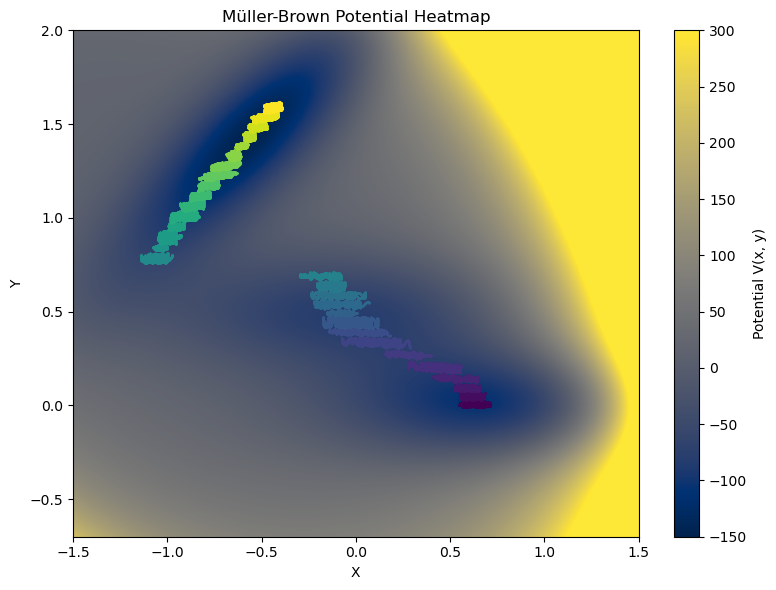

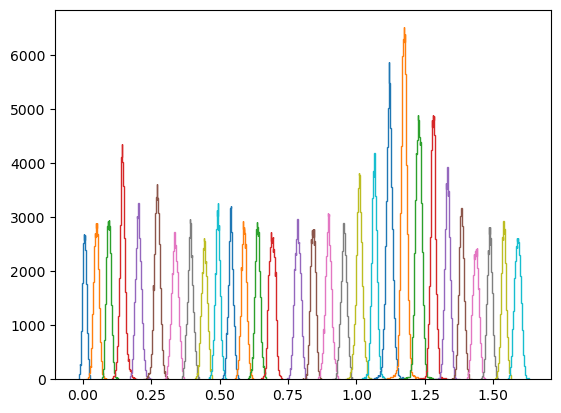

In [241]:
# Plot heatmap for one of the windows
fig, ax = plot_muller_brown_heatmap(cmap='cividis', vmin=-150, vmax=300, return_fig=True)
colors = plt.cm.viridis(np.linspace(0, 1, n_windows))
i = 0
for _,pos in enumerate(positions[:,-5000:]):
    ax.scatter(*pos.T, color=colors[_], s=0.1)
    i += 1
    
fig, ax = plt.subplots()
for pos in positions:
    ax.hist(pos[:, 1], bins=100, histtype='step', lw=1) 

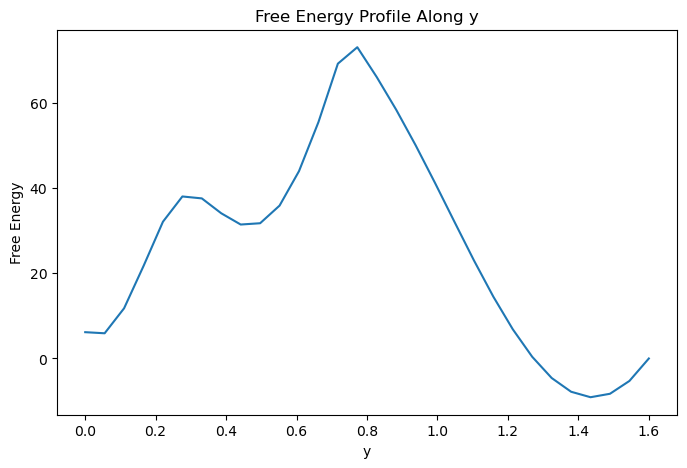

In [244]:
# Define the parameters
blocksize = 500  # Block size for averaging
n_windows = len(centers)  # Number of umbrella windows

# Prepare arrays for storing forces and positions
n_samples = positions.shape[1]
n_blocks = n_samples // blocksize
forces = np.zeros((n_blocks, n_windows))
samples = np.zeros((n_blocks, n_windows))

# Perform block analysis for each window
for c in range(n_windows):
    y_positions = positions[c, :, 1]  # Extract y-coordinates for this window
    for b in range(n_blocks):
        # Get block of data
        block_data = y_positions[b * blocksize:(b + 1) * blocksize]
        # Calculate mean force for the block
        forces[b, c] = np.mean(k_spring * (block_data - centers[c, 1]))
        # Calculate mean position for the block
        samples[b, c] = np.mean(block_data)

# Compute mean forces and positions across blocks
mean_forces = np.mean(forces, axis=0)
mean_samples = np.mean(samples, axis=0)

# Compute free energy profile by numerical integration
fes = -1 * integrate.cumulative_trapezoid(mean_forces, centers[:, 1], initial=0)
fes -= fes[-1]  # Normalize FES to zero at the endpoint

# Plot the free energy profile
plt.figure(figsize=(8, 5))
plt.plot(centers[:, 1], fes)
plt.xlabel("y")
plt.ylabel("Free Energy")
plt.title("Free Energy Profile Along y")
plt.show()

NEB did not converge within the maximum number of iterations.


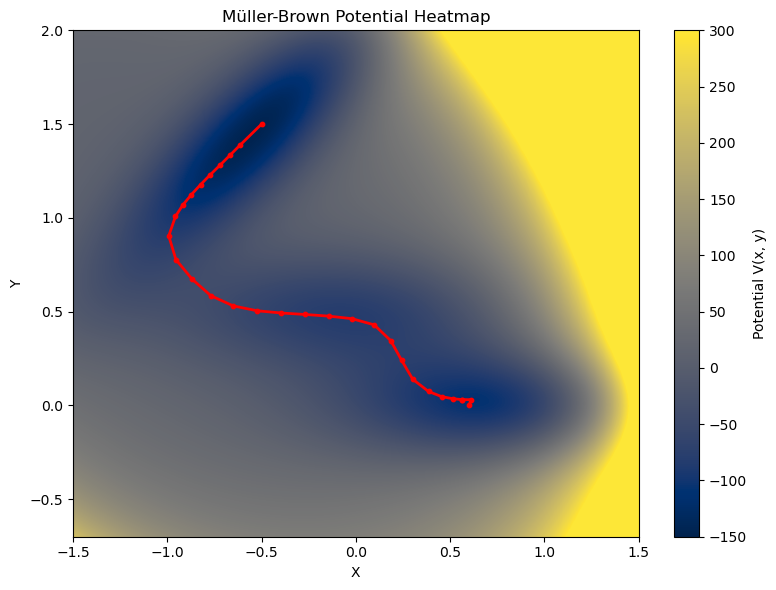

In [ ]:
def compute_neb_forces(images, k=1.0, max_force=5.0):
    """
    Computes the NEB forces for a given set of images.
    
    Parameters:
    - images (numpy.ndarray): Positions of images along the path.
    - k (float): Spring constant.
    - max_force (float): Maximum allowed force magnitude.

    Returns:
    - forces (list): List of forces on each intermediate image.
    """
    forces = []
    for i in range(1, len(images) - 1):
        # Tangent vector
        t_i = images[i + 1] - images[i - 1]
        t_i /= np.linalg.norm(t_i)

        # Spring force
        delta_prev = images[i] - images[i - 1]
        delta_next = images[i + 1] - images[i]
        spring_force = k * (np.linalg.norm(delta_next) - np.linalg.norm(delta_prev)) * t_i

        # True force
        _, grad_dx, grad_dy = mullerBrownPotentialAndGradient(images[i])
        grad = np.array([grad_dx, grad_dy])

        # Perpendicular component
        grad_parallel = np.dot(grad, t_i) * t_i
        grad_perpendicular = grad - grad_parallel

        # Total force
        f_total = spring_force - grad_perpendicular

        # Gradient clipping
        force_magnitude = np.linalg.norm(f_total)
        if force_magnitude > max_force:
            f_total = f_total / force_magnitude * max_force

        forces.append(f_total)
    return forces


def update_images(images, forces, learning_rate=0.001):
    """
    Updates the positions of the images along the NEB path based on computed forces.

    Parameters:
    - images (numpy.ndarray): Current positions of the images.
    - forces (list): Forces acting on each intermediate image.
    - learning_rate (float): Step size for updating image positions.

    Returns:
    - new_images (numpy.ndarray): Updated positions of the images.
    """
    new_images = images.copy()
    for i in range(1, len(images) - 1):
        new_images[i] += learning_rate * forces[i - 1]

        # Constrain x and y within bounds
        new_images[i][0] = np.clip(new_images[i][0], -1.5, 1.5)
        new_images[i][1] = np.clip(new_images[i][1], -0.7, 2.0)
    return new_images


# Parameters
N_images = n_windows
A_point = np.array([0.6, 0.0])
B_point = np.array([-0.5, 1.5])
images = np.linspace(A_point, B_point, N_images)

# NEB Optimization
max_iterations = 100000
tolerance = 1e-4
learning_rate = 0.001

for iteration in range(max_iterations):
    forces = compute_neb_forces(images, k=1.0, max_force=5.0)
    max_force_mag = max(np.linalg.norm(f) for f in forces)
    if max_force_mag < tolerance:
        print(f'Converged after {iteration} iterations.')
        break
    images = update_images(images, forces, learning_rate=learning_rate)
else:
    print('NEB did not converge within the maximum number of iterations.')


#  Extract free energy profile
energies = np.array([mullerBrownPotential(pos[0], pos[1]) for pos in images])

# Visualization
path = np.array(images)
fig,  ax  = plot_muller_brown_heatmap(cmap='cividis', vmin=-150, vmax=300, return_fig=True)
ax.plot(path[:, 0], path[:, 1],color='red', lw=2)
ax.scatter(path[:, 0], path[:, 1], color='red', s=10)

In [245]:
# Compute Boltzmann probabilities
boltzmann_weights = np.exp(-energies / temperature)
probabilities = boltzmann_weights / np.sum(boltzmann_weights)

# Compute reweighted free energy
energies = -temperature * np.log(probabilities)

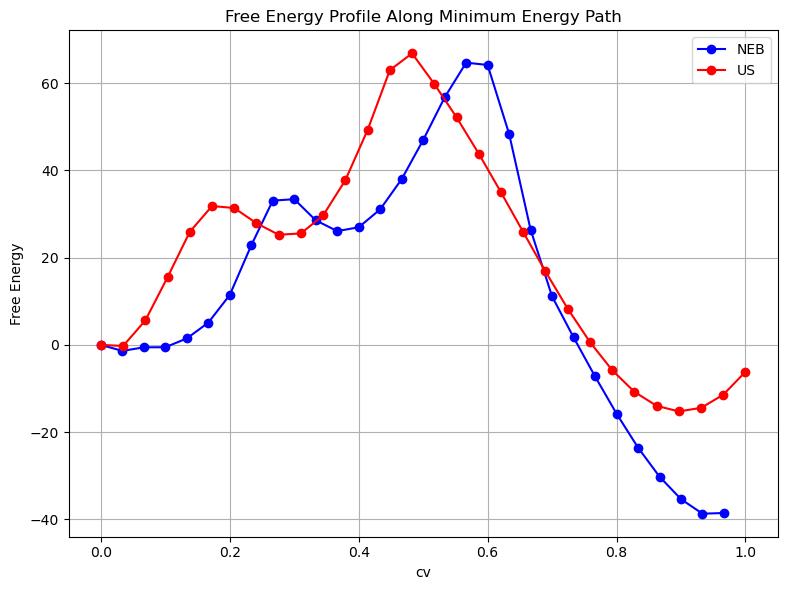

In [246]:
# Plot the free energy profile
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(images))/len(images), energies-energies[0], 'bo-', label='NEB')
plt.xlabel('Image Index')
plt.ylabel('Potential Energy (a.u.)')
plt.title('Free Energy Profile Along Minimum Energy Path')
plt.grid()
plt.legend()
plt.tight_layout()


# Plot the free energy profile
plt.plot(centers[:, 1]/np.max(centers[:,1]), fes-fes[0], 'ro-', label='US')
plt.xlabel("cv")
plt.ylabel("Free Energy")
plt.legend()
plt.show()